## Init TF

In [1]:
import numpy as np
import tensorflow as tf

#need to have these two lines to work on my ancient 1060 3gb
#  https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

from utils import *
import tensorflow_probability as tfp
import time
import os

#comment out for laptop use
from ipyvtklink.viewer import ViewInteractiveWidget

import pykitti
# from numba import cuda #gpu library used to clear gpu memory after each trial

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

Autosaving every 180 seconds


## ICET3D

In [ ]:
from ICET3D import ICET3D

settings.embedWindow(backend='ipyvtk', verbose = True)

plt = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

# basedir = 'C:/kitti/'
# date = '2011_09_26'
# drive = '0005'
# frame_range = range(150, 151, 1)
# dataset = pykitti.raw(basedir, date, drive)
# velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
# cloud1 = velo1[:,:3]
# cloud1_tensor = tf.convert_to_tensor(cloud1, np.float32)
# velo2 = dataset.get_velo(2) # Each scan is a Nx4 array of [x,y,z,reflectance]
# cloud2 = velo2[:,:3]
# cloud2_tensor = tf.convert_to_tensor(cloud2, np.float32)
cloud1_tensor = None
cloud2_tensor = None

nc = 15
mnp = 50
npts = 100000
D = False #draw sim
DG = False #draw grid
DE = True #draw ellipsoids
DC = True #draw correspondences
TD = True #use test dataset
CM = "voxel" #correspondence method, "voxel" or "NN"

start = time.time()
# #use whole point set
# #---------------------------------------------------------------------------------
# f = tf.constant([50,50,2]) #fidelity in x, y, z # < 5s
# lim = tf.constant([-100.,100.,-100.,100.,-10.,10.]) #needs to encompass every point
# Q, x_hist = ICET3D(cloud1_tensor[:npts], cloud2_tensor[:npts], plt, bounds = lim, 
#            fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG, 
#            draw_ell = DE, draw_corr = DC)
# #---------------------------------------------------------------------------------

#just consider small section of image where there are easily identifiable features:
#----------------------------------------------------------------------------------
limtest = tf.constant([-20.,0.,-20.,0.,-1.5,1.5])
# f = tf.constant([35,35,35])
# f = tf.constant([17,17,17])
f = tf.constant([21,21,21])
# cloud1_tensor = tf.squeeze(tf.gather(cloud1_tensor, tf.where( (cloud1_tensor[:,0] > limtest[0]))))	#only works one cond at a time

Q, x_hist, actual = ICET3D(cloud1_tensor, cloud2_tensor, plt, bounds = limtest, 
           fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG,
           draw_ell = DE, draw_corr = DC, test_dataset = TD, CM = CM)
#----------------------------------------------------------------------------------
#NOTE: Out of Memory Error comes from too high fidelity/ pts in cloud tensor --> 100x100x2x120,000 > 2gb

print("took", time.time() - start, "seconds total")

# print(tf.sqrt(tf.math.abs(Q)))
ans = np.sqrt(abs(Q.numpy()))
print("\n predicted solution standard deviation of error: \n",ans[0,0], ans[1,1], ans[2,2], ans[3,3], ans[4,4], ans[5,5])
# print("\n Q \n", Q)
# ViewInteractiveWidget(plt.window)

In [ ]:
#error
# x_hist[-1] + tf.constant([1., 3., 2., -0.12, -0.1, -0.2]) #T intersection
# x_hist[-1] + tf.constant([0., 1., 0., 0., 0., -0.1])      # simple wall
print(x_hist[-1] + actual)

# randy = tf.constant([tf.random.normal([1]).numpy(), tf.random.normal([1]).numpy(), 
#                   tf.random.normal([1]).numpy(), 0.03*tf.random.normal([1]).numpy(), 
#                   0.03*tf.random.normal([1]).numpy(), 0.1*tf.random.normal([1]).numpy()])
# randy = tf.squeeze(randy)
# print(randy)

In [ ]:
#display progression of solution values
from matplotlib import pyplot as plt
fig1 = plt.figure()
ax1 = fig1.add_subplot()
ax1.set_xlabel("iteration")
ax1.set_ylabel("estimated rotation (rad)")

# ax1.plot(x_hist.numpy())
# ax1.legend(['x','y','z','phi','theta','psi'])
ax1.plot(x_hist[:,3:].numpy())
ax1.legend(['phi','theta','psi'])

# ax1.plot(np.linspace(1,15,15), 0.02*np.ones(15), 'g--')
# ax1.plot(np.linspace(1,15,15), 0.03*np.ones(15), 'r--')
# ax1.plot(np.linspace(1,15,15), 0.01*np.ones(15), 'b--')

In [ ]:
fig2 = plt.figure()
ax2 = fig2.add_subplot()
ax2.set_xlabel("iteration")
ax2.set_ylabel("estimated translation (cm)")

# ax1.plot(x_hist.numpy())
# ax1.legend(['x','y','z','phi','theta','psi'])
ax2.plot(x_hist[:,:3].numpy())
ax2.legend(['x','y','z'])

# ax2.plot(np.linspace(1,15,15), -.1*np.ones(15), 'g--')
# ax2.plot(np.linspace(1,15,15), -3*np.ones(15), 'r--')
# ax2.plot(np.linspace(1,15,15), -.2*np.ones(15), 'b--')

## ICET Monte-Carlo Simulation

In [ ]:
plt = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

cloud1_tensor = None
cloud2_tensor = None
nc = 5
mnp = 50
npts = 100000
D = False #draw sim
DG = False #draw grid
DE = True #draw ellipsoids
DC = True #draw correspondences
TD = True #use test dataset
CM = "voxel" #correspondence method, "voxel" or "NN"
epochs = 100

# total_error = tf.zeros([1,6])
Q_total = tf.zeros([6,6])
errors = tf.zeros([1,6])

limtest = tf.constant([-20.,0.,-20.,0.,-1.5,1.5])
# f = tf.constant([35,35,35])
# f = tf.constant([17,17,17])
f = tf.constant([21,21,21])

for i in range(epochs):
    print("\n ~~~~~~~~~ Epoch ", i, " ~~~~~~~~~~~~~ \n")
    Q, x_hist, actual = ICET3D(cloud1_tensor, cloud2_tensor, plt, bounds = limtest, 
               fid = f, num_cycles = nc , min_num_pts = mnp, draw = D, draw_grid = DG,
               draw_ell = DE, draw_corr = DC, test_dataset = TD, CM = CM)

#     error_i = x_hist[-1] + tf.constant([1., 3., 2., -0.12, -0.1, -0.2]) #3D
    error_i = x_hist[-1] + tf.constant([1., 4., 2., -0., 0.0, -0.1]) # 2D
#     error_i = x_hist[-1] +  tf.constant([0., 1., 0., 0., 0., 0.1]) #1D
#     error_i = x_hist[-1] + actual
    
    # print("\n error_i \n", error_i)
    Q_total += Q
#     total_error += error_i
    errors = tf.concat((errors, error_i[None,:]), axis = 0)
errors = errors[1:] #get rid of placeholder value
    
# avg_error = total_error/epochs
# print("\n average solution errors \n", avg_error)
print("\n actual error std: \n", tf.math.reduce_std(errors, axis = 0))

ans = np.sqrt(abs((Q_total/epochs).numpy()))
print("\n predicted solution standard deviation of error: \n", ans[0,0], ans[1,1], ans[2,2], ans[3,3], ans[4,4], ans[5,5])

## get ground truth movement from pykitti

In [2]:
import pykitti
from metpy.calc import lat_lon_grid_deltas
import pyproj #package for cartographic projections

id1 = 0
id2 = 1
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0)
poses0 = dataset.oxts[id1] #<- ID of 1st scan
poses1 = dataset.oxts[id2] #<- ID of 2nd scan
print(poses0)

#get transformations in frame of OXTS inertial(?) sensor
lat0 = poses0.packet.lat
lon0 = poses0.packet.lon
alt0 = poses0.packet.alt
lat1 = poses1.packet.lat
lon1 = poses1.packet.lon
alt1 = poses1.packet.alt
# print(lat0, lon0, alt0)

#convert to dx/ dy in meters
#from metpy ------------------------------------------------
#these are "pint" objects which hold on to units
dx_oxts, dy_oxts = lat_lon_grid_deltas(np.array([lon0,lon1]), np.array([lat0, lat1]))
# print(dx_oxts, dy_oxts) 
dx_oxts = dx_oxts[0,0].magnitude
dy_oxts = dy_oxts[0,0].magnitude
# #---------------------------------------------------------
# #manual dxdy calculations (not sure if correct) ----------
# dx_oxts = (lon0-lon1)*40000*np.cos((lat0+lat1)*np.pi/360)/360 * 1000 
# dy_oxts = (lat0-lat1)*40000/360 * 1000
# print(dx_oxts, dy_oxts)
# #---------------------------------------------------------
dz_oxts = (alt0-alt1)
droll_oxts = (poses0.packet.roll - poses1.packet.roll)
dpitch_oxts = (poses0.packet.pitch - poses1.packet.pitch)
dyaw_oxts = (poses0.packet.yaw - poses1.packet.yaw)
# print(dx_oxts,dy_oxts,dz_oxts,droll_oxts, dpitch_oxts, dyaw_oxts)

#get rotation matrix to bring things into frame of lidar unit
rot = poses0.T_w_imu[:3,:3] #ignore reflectance componenet
# print(rot)
dxyz_oxts = np.array([[dx_oxts, dy_oxts, dz_oxts]])
dxyz_lidar = dxyz_oxts.dot(rot)
# print(dxyz_lidar, droll_oxts, dpitch_oxts, dyaw_oxts)

OxtsData(packet=OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0), T_w_imu=array([[ 3.41851748e-01,  9.39517225e-01, -2.10894666e-02,
         0.00000000e+00],
       [-9.39753895e-01,  3.41765417e-01, -7.68229696e-03,
         0.00000000e+00],
       [-1.00000000e-05,  2.24451150e-02,  9.99748077e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))


In [99]:
print(dataset.oxts[0]) #look at 100th datapoint
print("\n",dataset.oxts[0].packet.vf/10) #forard velocity at time 0

OxtsData(packet=OxtsPacket(lat=49.011212804408, lon=8.4228850417969, alt=112.83492279053, roll=0.022447, pitch=1e-05, yaw=-1.2219096732051, vn=-3.3256321640686, ve=1.1384311814592, vf=3.5147680214713, vl=0.037625160413037, vu=-0.03878884255623, ax=-0.29437452763793, ay=0.037166856911681, az=9.9957015129717, af=-0.30581030960531, al=-0.19635662515203, au=9.9942128010936, wx=-0.017332142869546, wy=0.024792163815438, wz=0.14511808479348, wf=-0.017498934149631, wl=0.021393359392165, wu=0.14563031426063, pos_accuracy=0.49229361157748, vel_accuracy=0.068883960397178, navstat=4, numsats=10, posmode=4, velmode=4, orimode=0), T_w_imu=array([[ 3.41851748e-01,  9.39517225e-01, -2.10894666e-02,
         0.00000000e+00],
       [-9.39753895e-01,  3.41765417e-01, -7.68229696e-03,
         0.00000000e+00],
       [-1.00000000e-05,  2.24451150e-02,  9.99748077e-01,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]]))

 0.35147680214713


In [199]:
import datetime
# print(type(dataset.timestamps[50]))
# print(dataset.timestamps[50].time())

t = 0
for n in range(150):
#     print((dataset.timestamps[n+1] - dataset.timestamps[n]).microseconds/(10e5))
    t += (dataset.timestamps[n+1] - dataset.timestamps[n]).microseconds/(10e5)

print(t/150)

# dif = datetime.timedelta()
# print(datetime.timedelta(dataset.timestamps[50],dataset.timestamps[51]))

0.10327142


## Plot results of ICET estimates on KITTI lidar point clouds vs GPS/INS baseline

<IPython.core.display.Javascript object>


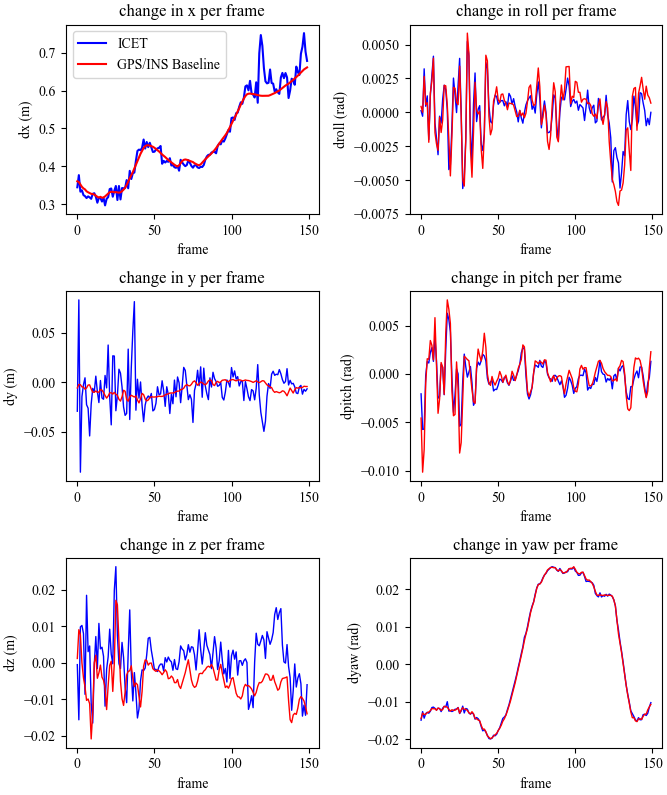

In [244]:
import matplotlib.pyplot as plt
font = {'fontname':'Times New Roman'}

# ICET_estimates = np.loadtxt("ICET_estimates_926_005.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_005.txt")

OXTS_baseline = np.loadtxt("OXTS_baseline_926_test2.txt") #best baseline

ICET_estimates = np.loadtxt("ICET_estimates_926_test3.txt") #[20,20,2]
# ICET_estimates = np.loadtxt("ICET_estimates_926_test4.txt") #[50,50,2]

# ICET_estimates = np.loadtxt("ICET_estimates_926_0018.txt")
# # ICET_estimates[:,1] = -ICET_estimates[:,1]
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_0018.txt")
# # OXTS_baseline[:,1] = -OXTS_baseline[:,1]

n = 5
def moving_avg(x, n):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[n:] - cumsum[:-n]) / float(n)

#fix sign errors...
ICET_estimates[:,1] = -ICET_estimates[:,1]
ICET_estimates[:,3:] = -ICET_estimates[:,3:]
style1 = 'b-'
style2 = 'r-'

fig, ax = plt.subplots(3,2, constrained_layout = True)
ax[0,0].plot(ICET_estimates[:,0], style1, label = 'ICET')
ax[0,0].plot(OXTS_baseline[:,0], style2, label = 'GPS/INS Baseline')
# ax[0,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,0], n),  style2, label = 'GPS/INS Baseline')
ax[0,0].set_title("change in x per frame", **font)
ax[0,0].set_ylabel("dx (m)", **font)
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_xlabel("frame", **font)

ax[1,0].plot(ICET_estimates[:,1], style1, lw = 1)
ax[1,0].plot(-OXTS_baseline[:,1], style2, lw = 1)
# ax[1,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,1], n),  style2, lw = 1)
ax[1,0].set_title("change in y per frame", **font)
ax[1,0].set_ylabel("dy (m)", **font)
ax[1,0].set_xlabel("frame", **font)


ax[2,0].plot(ICET_estimates[:,2], style1, lw = 1)
ax[2,0].plot(OXTS_baseline[:,2], style2, lw = 1)
# ax[2,0].plot(np.arange(n//2, np.shape(ICET_estimates)[0] - n//2 ), moving_avg(OXTS_baseline[:,2], n),  style2, lw = 1)
ax[2,0].set_title("change in z per frame", **font)
ax[2,0].set_ylabel("dz (m)", **font)
ax[2,0].set_xlabel("frame", **font)

ax[0,1].plot(ICET_estimates[:,3], style1, lw = 1)
ax[0,1].plot(OXTS_baseline[:,3], style2, lw = 1)
ax[0,1].set_title("change in roll per frame", **font)
ax[0,1].set_ylabel("droll (rad)", **font)
ax[0,1].set_xlabel("frame", **font)


ax[1,1].plot(ICET_estimates[:,4], style1, lw = 1)
ax[1,1].plot(OXTS_baseline[:,4], style2, lw = 1)
ax[1,1].set_title("change in pitch per frame", **font)
ax[1,1].set_ylabel("dpitch (rad)", **font)
ax[1,1].set_xlabel("frame", **font)


ax[2,1].plot(ICET_estimates[:,5], style1, lw = 1)
ax[2,1].plot(OXTS_baseline[:,5], style2, lw = 1)
ax[2,1].set_title("change in yaw per frame", **font)
ax[2,1].set_ylabel("dyaw (rad)", **font)
ax[2,1].set_xlabel("frame", **font)

# fig.tight_layout(h_pad = 0.1)
plt.show()

# fname = "assets/005.png"
# plt.savefig(fname)

<IPython.core.display.Javascript object>


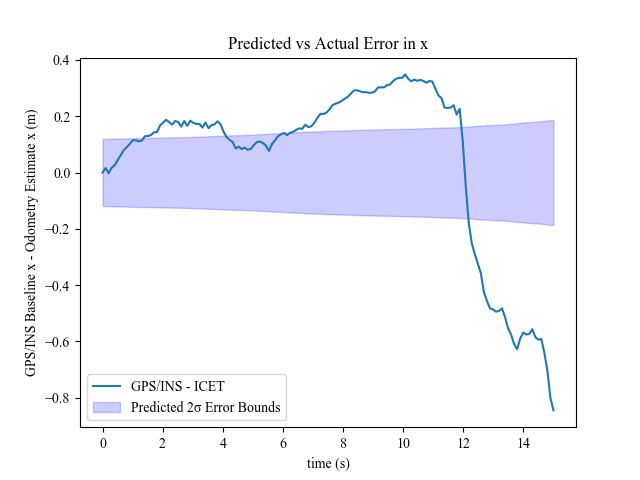

Text(0, 0.5, 'GPS/INS Baseline x - Odometry Estimate x (m)')

In [246]:
#plot error between ICET and absolute position
plt.rc('font',family='Times New Roman')
fig3, ax3 = plt.subplots(1,1)

#load data on estimated standard deviations of each component
ICET_pred_stds = np.loadtxt("ICET_pred_stds_926_test3.txt")
# ICET_pred_stds = np.loadtxt("ICET_pred_stds_926_test4.txt")

#which component to look at
# c = 5 #yaw
c = 0 # x (forward movement)
window = 5

#raw - not that useful since GPS/INS is only an ESTIMATE, errors are +/- 2cm
diffx = OXTS_baseline[:,c] - ICET_estimates[:,c]

#most honest comparison- smoothed OXTS, raw ICET
# diffx = moving_avg(OXTS_baseline[:,c], window) - ICET_estimates[(window//2):-window//2+1,c]

#much cleaner - smoothing both
# diffx = moving_avg(OXTS_baseline[:,c], window) - moving_avg(ICET_estimates[:,c], window)
# diffx = moving_avg(OXTS_baseline[:,c] - ICET_estimates[:,c], window)

#adjust so means are the same?? --don't do this...
# shift = np.mean(OXTS_baseline, axis = 0) - np.mean(ICET_estimates, axis = 0)
# print(shift)
# diffx -= shift[c] 

# new 1/23 -------------
# combine sigmas for OXTS (fused GPS/INS) and Lidar
#  this is a litte tricky since the OXTS erros are time dependant so we need to look at cumulative 
#  differences for both

cum_err = np.zeros(np.shape(ICET_pred_stds))
cum_diffx = np.zeros(np.shape(diffx))
for i in range(np.shape(ICET_pred_stds)[0]):
    cum_err[i,:] = np.sum(ICET_pred_stds[:i,:]**2, axis = 0)
    #add in baseline OXTS 1-sigma errors
    cum_err[i,:] += np.sqrt(2)*np.array([0.05,0.05,0.1,0.0001,0.0001,0.0002])**2
    cum_err[i,:] = np.sqrt(cum_err[i,:]) 
    
for j in range(np.shape(diffx)[0]):
    cum_diffx[j] = np.sum(diffx[:j]) 
    
 # ----------------------


#old
# ax3.plot(diffx, label = 'GPS/INS - ICET')
# ax3.fill_between(np.linspace(0,(150-window//2+1),150), -2*ICET_pred_stds[:,c], 2*ICET_pred_stds[:,c], 
#                  color = (0,0,1,0.2), label = 'ICET Predicted 2σ Error Bounds')

#new
ax3.plot(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), cum_diffx, label = 'GPS/INS - ICET')
ax3.fill_between(np.linspace(0,15,np.shape(ICET_pred_stds)[0]), -2*cum_err[:,c], 2*cum_err[:,c], 
                 color = (0,0,1,0.2), label = 'Predicted 2σ Error Bounds')

ax3.legend(loc = 'lower left')
ax3.set_title("Predicted vs Actual Error in x")
ax3.set_xlabel("time (s)", **font)
ax3.set_ylabel("GPS/INS Baseline x - Odometry Estimate x (m)", **font)
# ax3.set_ylim([-0.07,0.07])

In [52]:
# print(ICET_pred_stds[0,:])
test = tf.zeros([6,1])
print(test)
# print(np.sqrt(test))


tf.Tensor(
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]], shape=(6, 1), dtype=float32)


In [ ]:
#TODO- get r^2 value of relationship between Q[i,0] and actual error of estimates

<IPython.core.display.Javascript object>


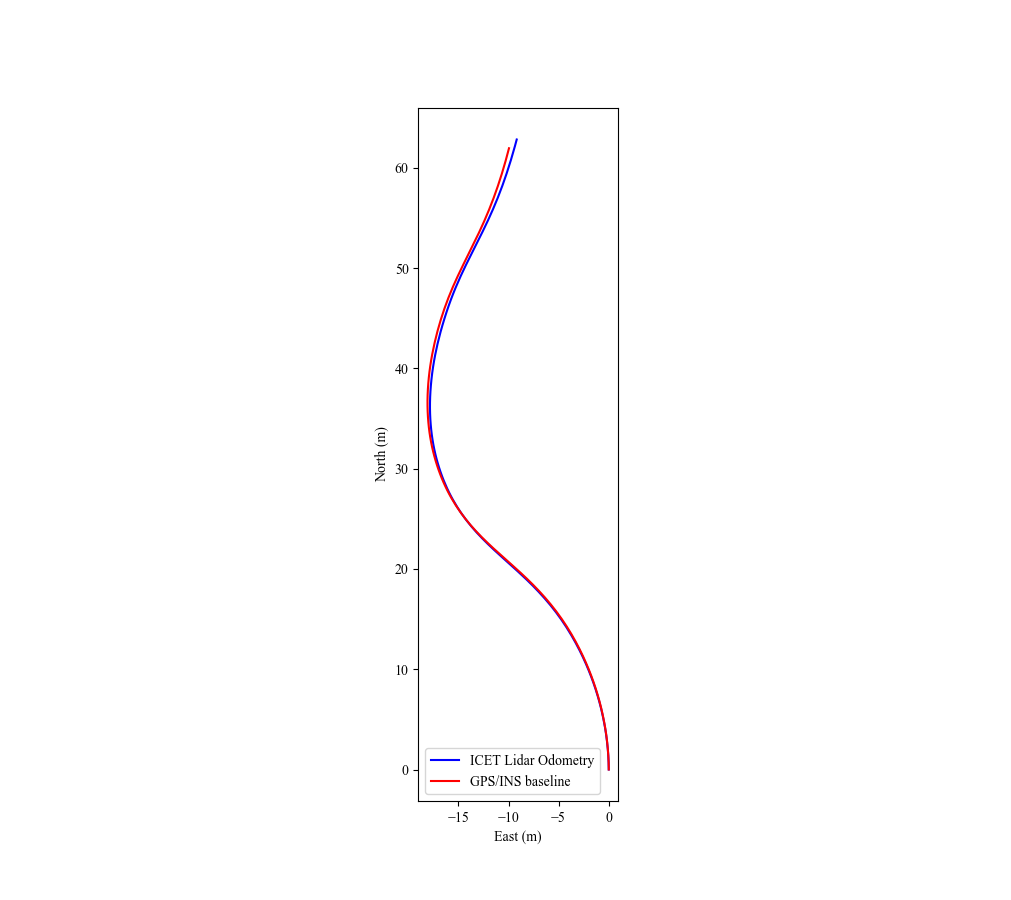

C:\Users\Derm\anaconda3\envs\robot\lib\site-packages\ipykernel_launcher.py:33: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


In [256]:
#plot xy total positions
fig2, ax2 = plt.subplots(1,1)
ax2.set_aspect('equal')

# ICET_estimates = np.loadtxt("ICET_estimates_926_0018.txt")
# OXTS_baseline = np.loadtxt("OXTS_baseline_926_0018.txt")

OXTS_total = np.zeros(np.shape(OXTS_baseline))
ICET_total = np.zeros(np.shape(ICET_estimates))

for i in range(np.shape(OXTS_baseline)[0]):
    OXTS_total[i] = np.sum(OXTS_baseline[:i], axis = 0)
    ICET_total[i] = np.sum(ICET_estimates[:i], axis = 0)
# ax2.plot(ICET_total[:,5])
# ax2.plot(OXTS_total[:,5])

#need to combine TOTAL heading with incremental changes in x and y (really should be ignoring y...)
ICET_traj = np.zeros([np.shape(ICET_estimates)[0], 2])
OXTS_traj = np.zeros([np.shape(ICET_estimates)[0], 2])
for j in range(1, np.shape(ICET_estimates)[0]):
    #x[i] = x[i-1] + step_dist*cos(heading)
    ICET_traj[j,0] = ICET_traj[j-1,0] + ICET_estimates[j,0]*np.cos(ICET_total[j,5]) #+ ICET_estimates[j,1]*np.sin(ICET_total[j,5])
    OXTS_traj[j,0] = OXTS_traj[j-1,0] + OXTS_baseline[j,0]*np.cos(OXTS_total[j,5]) #+ OXTS_baseline[j,1]*np.sin(OXTS_total[j,5])
    #y[i] = y[i-1] + step_dist*sin(heading)
    ICET_traj[j,1] = ICET_traj[j-1,1] + ICET_estimates[j,0]*np.sin(ICET_total[j,5]) #+ ICET_estimates[j,1] * np.cos(ICET_total[j,5])
    OXTS_traj[j,1] = OXTS_traj[j-1,1] + OXTS_baseline[j,0]*np.sin(OXTS_total[j,5]) #+ OXTS_baseline[j,1] * np.cos(OXTS_total[j,5])

    
ax2.plot(ICET_traj[:,1], ICET_traj[:,0],   'b-', label = "ICET Lidar Odometry")
ax2.plot(OXTS_traj[:,1], OXTS_traj[:,0], 'r-', label = 'GPS/INS baseline')
ax2.set_xlabel('East (m)', **font)
ax2.set_ylabel('North (m)', **font)
ax2.legend(loc = 'bottom left')

# plt.show()

In [ ]:
#get ground truth poses from text file??
path = r"C:\kitti\2011_09_26\2011_09_26_drive_0005_sync\poses\05.txt"
gt = np.loadtxt(path)
print(gt[0, :6])
print(gt[2, :6])
print(np.shape(gt))
# print(gt[-1, :6])

## Parse XML file containing ground truth KITTI data

In [ ]:
from bs4 import BeautifulSoup

# Reading the data inside the xml
# file to a variable under the name
# data
file = r'C:\kitti\2011_09_26\2011_09_26_drive_0005_sync\tracklet_labels.xml'
with open(file, 'r') as f:
    data = f.read()

# the beautifulsoup parser, storing
# the returned object
Bs_data = BeautifulSoup(data, "xml")
 
# Finding all instances of tag
# `tx`
x = Bs_data.find_all('tx')
# print(x[150])
print(x)

# Using find() to extract attributes
# of the first instance of the tag
b_name = Bs_data.find('child', {'name':'Frank'})
 
print(b_name)
 
# Extracting the data stored in a
# specific attribute of the
# `child` tag
value = b_name.get('test')
 
print(value)

In [ ]:
print(tf.reduce_mean(errors, axis = 0))

#save to external file---
# fn = "2d_errors.txt"
# np.savetxt(fn, errors.numpy())

In [ ]:
a = tf.linspace(1.,10.,10)
print(a)
mask = tf.cast(tf.math.less(a, 4), tf.float32)
print(mask)
a = a*mask
print(a)
print(tf.math.reduce_max(tf.constant([1.,2.,9.])))
print(tf.math.abs([-1.,2.,3.,-0.5]))

In [ ]:
#GOAL: Keep distribution axis for neighboring ellipses on the same surface pointing in the same direction
#      if I don't do this, it will mess up my z-error??

# if largest absolute value element in 3rd column of U[i] is less than 0, multiply U[i] by -1
U = tf.constant([[[1., 2.,  4.],
                  [0., 3., -1.],
                  [1., 3., -6.]],
                  
                 [[3., 2.,  1.],
                  [0., 2.,  -9.],
                  [9., 1.,  6.]],
                
                 [[1., 1.,  -1.],
                  [1., 1.,  3.],
                  [1., 1.,  5.]]])

print(U, "\n")
# #slow loopy way
# print("slower way ----------------------------")
# for i in range(tf.shape(U)[0]):
#     a = tf.math.reduce_max(tf.abs(U[i,:,2]))
#     print(a)
#     b = tf.where(tf.equal(tf.abs(U[i,:,2] ), a ))[0,0]
#     print(b) 
#     print(U[i,b,2])
#     if U[i,b,2] < 0:
#         print("gotta reverse U \n")

#faster vectorized way
print("\n faster way ---------------------")
a = tf.math.reduce_max(tf.abs(U[:,:,2]), axis = 1)[:,None]
# print(a)
b = tf.where( tf.math.equal(tf.abs(U[:,:,2]), a) )
# print(b)
# print("U[:,:,2] \n", U[:,:,2])
absmax = tf.gather_nd(U[:,:,2], b)
print("absmax: \n", absmax)

#test: only look at one comonent of direction of largest ditribution axis
# absmax = U[:,0,2]
# print(absmax)

mask = (-2.*tf.cast(tf.math.less(absmax, 0), tf.float32) + tf.ones(tf.shape(absmax)))[:,None][:,None]
print("mask: \n", mask)

# print("output: ", mask*U)


In [ ]:
L = tf.tile(tf.eye(3)[None,:,:], (2, 1, 1))
print(L)

In [ ]:
#test out multiplying voxel means by either ragged tensor or by zero padded (3x3) tensor
# make sure results are the same
#BAD WAY...

L1 = tf.constant([[[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 1.]],

                [[0., 0., 0.],
                 [0., 0., 0.],
                 [0., 0., 0.]],
                
                [[1., 0., 0.],
                 [0., 1., 0.],
                 [0., 0., 0.]]])

values = tf.tile(tf.eye(3), (3,1))
useful = tf.constant([0,1,2,6,7]) #useful directions for ICET
uv = tf.gather(values, useful)
print("uv: \n", uv)

# starts = [0, 3, 4]
# L2 = tf.RaggedTensor.from_row_starts(values, starts)

#find where first element of each row is equal to 1
# w = tf.transpose(tf.where(uv[:,0] == 1))
# print("w \n", w)

#find where every first row is NOT 1 so we can add those to row_limits to create placeholder zero tensors
everyThird = tf.range(0,tf.shape(values)[0],3, dtype = tf.int64)[None,:]
print("\n every third \n", everyThird)
#find elements of everyThird that are not in <useful>
both = tf.sets.intersection(everyThird, tf.cast(useful, tf.int64)[None,:])
both = tf.sparse.to_dense(both)
print("\n both \n ", both)
placeholers = tf.where(everyThird == both)

row_limits = [3,3,5] #temp -> write code to gen this automatically

L2 = tf.RaggedTensor.from_row_limits(uv, row_limits)
print("\n L2 \n", L2.to_tensor())

test1 = L1 @ U
# print("\n test1 \n", test1)

# test2 = L2.to_tensor() @ U
# print("\n test2 \n", test2)
# print(L2)



In [ ]:
#Better way...
I = tf.tile(tf.eye(3), (4,1))
print("eye \n", I)
short = tf.constant([0,1,2,6,7,9]) #useful directions for ICET
print("\n useful \n", useful)

data = tf.ones((tf.shape(short)[0],3))
print("\n data \n", data)

mask = tf.scatter_nd(indices = short[:,None], updates = data, shape = tf.shape(I))
print("\n mask \n", mask)

ans = mask * I
ans = tf.reshape(ans, (tf.shape(ans)[0]//3,3,3))
print("\n ans \n",ans)

In [ ]:
tf.range(0,tf.shape(values)[0],3)

### Proof that extended axis truncation == etended axis zeroing

In [ ]:
L1 = tf.constant([[1., 0., 0.],
                  [0., 1., 0.],
                  [0., 0., 0.]])
print("\n L1 \n", L1)

L2 = tf.constant([[1., 0., 0.],
                  [0., 1., 0.]])
print("\n L2 \n", L2)

U = R(tf.constant([1.,2.,3.]))

sigma = tf.random.uniform((3,3))

#fake calculation of R_noise
test1 = L1 @ tf.transpose(U) @ sigma @ U @ tf.transpose(L1)
print("\n test1 \n", test1)

test2 = L2 @ tf.transpose(U) @ sigma @ U @ tf.transpose(L2)
print("\n test1 \n", test2)


In [ ]:
#truncating L matrix does the same thing as zeroing out end rows...
L3 = tf.constant([[1.,0.,0.],
                  [0., 1., 0.]])
print(L3 @ U[0])
print(L1[2] @ U[0])

In [ ]:
#test - multiply a [6,6] tensor with a [N, 6, 3] tensor
# A = tf.eye(6)        #[6, 6]
# B = tf.ones([2,6,3]) #[2, 6, 3]
# print(tf.shape(tf.matmul(A,B))) #[2, 6, 3]

C = tf.ones([164, 6,3])
D = tf.ones([164,3])[:,:,None]
print(tf.shape(tf.matmul(C,D)))

In [ ]:
a = tf.ones([2,3,3])
b = tf.ones([2,3,3])
# print(a, b)
print(a * b)
print(a @ b)
print(tf.matmul(a,b))

In [ ]:
t = tf.random.uniform([10,3])
print(t)
lims = [tf.constant([1]), tf.constant([2])]
rag = tf.RaggedTensor.from_row_splits(t, lims)
print(rag)

## Subdivide scan using NumPy

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

try:
    plt1.closeWindow()
    print("closed")
except:
    pass

plt1 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)
# settings.useParallelProjection = True #makes view orthographic

## uncomment to use VOLPE dataset -----------------------------------------------------
# location = 'C:/Users/Derm/2021-03-10-16-43-50_Velodyne-VLP-16-Data_garminSignage.txt'
# cloud = np.loadtxt(open(location, "rb"), delimiter=",")
# cloud = cloud[~np.isnan(cloud).any(axis=1)] #remove all rows with NaN elements
## ------------------------------------------------------------------------------------

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
## ------------------------------------------------------------------------------------

# make 2D sinusioal pattern (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
##-------------------------------------------------------------------------------------

# f =np.array([200,200,40]) #fidelity in x, y, z #takes ~30s on my dsektop
# lim = np.array([-50,50,-50,50,-10,10])

f =np.array([100,100,2]) #fidelity in x, y, z # < 5s
lim = np.array([-100,100,-100,100,-10,10])

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,100)), tf.int32))
    cloud_partial = cloud
    mus, sigmas, sizes = subdivide_scan(cloud_partial,plt1, bounds = lim, fid = f, draw_grid = False, show_pc = True) 

# print("\n mus: \n", mus)
# print("\n sigmas: \n", sigmas, np.shape(sigmas))
    
ViewInteractiveWidget(plt1.window)

## Subdivide scan using TensorFlow

In [ ]:
## from vedo import *
from utils import *
import numpy as np
import os
from ipyvtklink.viewer import ViewInteractiveWidget
import pykitti

settings.embedWindow(backend='ipyvtk', verbose = True) #was this

plt2 = Plotter(N=1, axes=1, bg = (0.1,0.1,0.1), bg2 = (0.3,0.3,0.3),  interactive=True)

## uncomment to use KITTI dataset -----------------------------------------------------
basedir = 'C:/kitti/'
date = '2011_09_26'
drive = '0005'
frame_range = range(150, 151, 1)
dataset = pykitti.raw(basedir, date, drive)
velo1 = dataset.get_velo(0) # Each scan is a Nx4 array of [x,y,z,reflectance]
cloud = velo1[:,:3]
cloud_tensor = tf.convert_to_tensor(cloud, np.float32)
# print(tf.shape(cloud))
## ------------------------------------------------------------------------------------

# # make 2D sinusioal motion (for debug) ------------------------------------------------
# cloud = np.random.randn(10000,3)
# cloud[:,0] += -50*cloud[:,1] + np.random.randn()*5
# cloud[:,1] += 5
# cloud[:,1] = cloud[:,1] * 3 + 10*np.random.randn() + np.sin(cloud[:,1]*5)*10
# cloud[:,2] += 0.5*cloud[:,1] - 10
# #-------------------------------------------------------------------------------------

f = tf.constant([100,100,2]) #fidelity in x, y, z # < 5s
lim = tf.constant([-100.,100.,-100.,100.,-10.,10.])
DRAW = True

for _ in range(1):
#     cloud_partial = tf.gather(cloud,tf.cast((tf.linspace(1,100000,30)), tf.int32))
    cloud_partial = cloud
    E = subdivide_scan_tf(cloud_partial, plt2, bounds = lim, fid = f, draw=DRAW, draw_grid = False, show_pc = 1) 
# print("\n points: \n", cloud_partial)

# mu = E[0]
# print("\n mu: \n",mu)

# sigma = E[1]
# print("\n sigma: \n", sigma)

# print(tf.transpose(sigma))
# print("\n sigma[:,:,1] \n", sigma[:,:,0])

# sig2 = tf.reshape(tf.transpose(sigma), (tf.shape(sigma)[1] ,3,3))
# print("reshaped sigma \n", sig2)

# shapes = E[2]
# print("\n shapes: \n", shapes)

# sigma = E[1]
# print(tf.shape(sigma),sigma[:,:,1])

# if DRAW:
ViewInteractiveWidget(plt2.window)


### kNN

In [ ]:
# a = tf.constant([1.,1.,1.]) #works ------------------------------
# print("\n a \n", a)

# b = tf.random.normal([10,3])
# print("\n b \n", b)

# dist = tf.reduce_sum(tf.math.squared_difference(a,b), axis = 1)
# ans = tf.where(dist == tf.math.reduce_min(dist))[0,0]
# print("\n ans \n", b[ans])
## -----------------------------------------------------------------

# batch input - not working yet ------------------------------------
a = tf.constant([[[1., 1., 1.]],
                 [[0., 0., 0.]],
                 [[0., 0., 0.]]])  
print("\n a \n", a)

b = tf.random.normal([10,3])
print("\n b \n", b)

# print(tf.gather(a,(0,1)))
# print(tf.math.subtract(a, b))
# print(tf.square(a-b))
dist = tf.math.reduce_sum( (tf.square( tf.math.subtract(a, b) ))  , axis = 2)
print("\n dist \n", dist)

ans = tf.where( tf.transpose(dist) ==tf.math.reduce_min(dist, axis = 1))
print("\n shortest dist \n", ans)

reordered = tf.argsort(ans[:,1], axis = 0)
print("\n reordered \n", tf.gather(ans,reordered))


### Create ragged tensor given row sizes

In [ ]:
sizes = tf.constant([1,2,8,4,5])

# dummy_vals would be (points_x - mu_x)
v = tf.random.uniform([tf.math.reduce_sum(sizes)])
dummy_vals = tf.RaggedTensor.from_row_lengths(v ,sizes) 
print(dummy_vals.to_tensor() - 1)
mask_test = tf.RaggedTensor.from_row_lengths(tf.ones(tf.math.reduce_sum(sizes)) ,sizes)
print(tf.transpose(mask_test.to_tensor()))
print((dummy_vals.to_tensor() -1) * mask_test.to_tensor())

## Unit Test R() and Jacobian

In [ ]:
n_hat = np.array([1,0,0])
theta =  0.1 #np.pi/6 #rad

rot_mat_simp = R_simp(n_hat, theta)
print(rot_mat_simp)
angs = np.array([theta,0 ,0])
rot_mat = R(angs)
print(rot_mat)

print(R2Euler(rot_mat))

p_point = np.array([1,1,1]).T

J = jacobian(angs, p_point)

d_rot_mat_simp = dR_simp(n_hat,theta)
# print(d_rot_mat_simp)

## Unit test R2Euler_tf and R_tf
#### Works with single axis roation
#### Works with vectoried input
#### Solution becomes ambiguious with mutliple axis inputs

In [ ]:
angs = tf.random.normal((3,1)) * tf.constant([[0.], [0.], [1.] ]) #single axis angle input
# angs = tf.Variable([[0.],[ np.pi/2],[ 0.]]) #vector input, multiple axis rotation
print("Input angs: \n", angs.numpy())
# print("R(angs): \n", R_tf(angs).numpy())
test1 = R2Euler_tf(R_tf(angs))
print("R2Euler_tf(R(angs)): \n", test1.numpy())
# test2 = R2Euler(R(angs[:,:2]))
# print(test2)

### Unit test tfp find bins

In [ ]:
c = tf.convert_to_tensor(cloud, np.float32)#[:100]
# print("c: \n", c.numpy())
startx = -100.
stopx = 100.
numx = 10
edgesx = tf.linspace(startx, stopx, numx)
xbins = tfp.stats.find_bins(c[:,0], edgesx)
print(xbins)
starty = -100.
stopy = 100.
numy = 10
edgesy = tf.linspace(starty, stopy, numy)
ybins = tfp.stats.find_bins(c[:,1], edgesy)
print(ybins)

min_num_pts = 1000

count = 0
E = []

for x in range(numx):
    for y in range(numy):
        #only do calculations if there are a sufficicently high number of points in the bin
        xin = tf.where(xbins == x)
        if tf.shape(xin)[0] > min_num_pts:
            if tf.shape(tf.where(tf.gather(ybins, xin) == y))[0] > min_num_pts: #repeat for y points at x coord
#                 print("working", x, y)
                count += 1
# print(xin)
# print(ybins)
print(count)

In [ ]:
test = tf.linspace(1,5,5)
print(test)
ans = tf.where(test < 4)
print("ans: \n",ans)
print("\n", tf.gather(test, ans))


## Inline volumetric rendering using ipyvolume

In [ ]:
#simple demo
import ipyvolume
ds = ipyvolume.datasets.aquariusA2.fetch()
short = ds.data[:,:,:]
ipyvolume.quickvolshow(short, lighting=True)

In [ ]:
ans = np.linspace(1,12,8)
ans[2] = 0
print(ans)

test = ans[ans < 10]
print(test)
np.shape(test)[0]

print(np.median(test[:3]))

In [ ]:
tes = tf.random.normal([3,3])
print(tes)
print(tf.reverse(tes, axis = [1]))

In [ ]:
# a = tf.reshape([10.,10.,2.], (3,1))
# print(type(a))
# t = tf.Tensor(a, dtype = "float32")

a = tf.constant([2.1,2.,3.])
b = tf.constant([1.,2.,3.])
tf.tensordot(a,b, axes = 0)

In [ ]:
eye = tf.eye(3)
# print(j)
Jx = tf.constant([[1.], [2.], [3.]])
J = tf.concat([eye, Jx], axis = 1)
print(J)

### compare jacobian() and jacobian_tf()

In [ ]:
# print(tf.sin(1.))
start = time.time()
numiter = 1000
angs  = np.array([1.,0.1,0.1])
p_point = np.array([1.,2.,3.])
for _ in range(numiter):
    J = jacobian(angs, p_point);
print("took", time.time()-start, "seconds on CPU")
print(J)

In [ ]:
#TF is slower if we do them one by one BUT is waaay faster if we send them in all at once
start = time.time()
numiter = 1000
# angs = tf.random.normal((3,numiter))
angs = tf.constant([1.,2.,3.])
p_point = tf.random.normal((3,numiter))
J = jacobian_tf(p_point, angs);
print("took", time.time()-start, "seconds on GPU")
print(J)

### Testing subdividing cells without loop

In [ ]:
#Goal: given input tensor "cloud" and "bins" which contains all og and binned coordinates
#      subdivide and perform ops on "cloud" wihtout using any loops 

bins = tf.transpose(tf.constant([[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.],
                                 [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                 [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]))
cloud = bins + tf.random.normal(tf.shape(bins))*0.1
print("binned coordinate values: \n", bins)
# print(cloud)

#1d case (easy)
# q = tf.constant([1., 1., 2.]) 
# print(tf.squeeze(tf.gather(bins, ans))) #works for 1d, unsure of utility in 2d
#2d case (hard)
q = tf.constant([[[1., 1., 2.]],
                 [[0., 9., 9.]],
                 [[2., 0., 1.]],
                 [[7., 8., 9.]]])
print("\n cells of interest: \n",q)

idx = tf.equal(bins, q)
print(idx)
#ans outputs tensor of shape [N,2], where:
#  [[voxel number, index of [x,y,z] in cloud that corresponds to bin #],
#   [voxel number,index of [x,y,z] in cloud that corresponds to bin #]] ... 
loc = tf.where(tf.math.reduce_all(idx, axis = 2) == True)
print("\n loc: \n", loc)

#Need to "ungroup" so that we can fit_gaussian_tf() to each individual voxel...
s = tf.shape(loc)
group_ids, group_idx = tf.unique(loc[:, 0], out_idx=s.dtype)
num_groups = tf.reduce_max(group_idx) + 1
# print(group_ids, group_idx, num_groups)
sizes = tf.math.bincount(group_idx)
# print(sizes)

#replace <bins> here with <cloud> when done debugging
rag = tf.RaggedTensor.from_row_lengths(tf.gather(cloud, loc[:,1]), sizes) 
# print("ragged: \n", rag)

#Run on GPU as vectorized operation (WAAAAAY Faster) --
reg = tf.RaggedTensor.to_tensor(rag)
print("\n regular tensor: \n", reg)
mu, sigma = fit_gaussian_tf(reg)
print("mu: \n", mu)
print("sigma: \n", sigma)
#------------------------------------------------------- 

# # works but uses loop (runs on CPU -> slow) -----------
# A =  tf.data.Dataset.from_tensor_slices(rag)
# mus = []
# sigmas = []
# for i in range(len(A)):
#     mu, sigma = fit_gaussian_tf(rag[i])
#     mus.append(mu)
#     sigmas.append(sigma)
# print(mus, sigmas)
# #------------------------------------------------------

### Find "loc" more efficiently than using tf.where

In [ ]:
print("binned points: \n", bins)
print("\nbins to place them: \n",q)

# #SUPER inefficient 
# for i in range(tf.shape(bins)[0]):
#     for j in range(tf.shape(q)[0]):
#         if tf.reduce_all(bins[i] == q[j]):
#             print(j,i)
#             try:
#                 loc2 = tf.concat((loc2, tf.constant([[j,i]])), axis = 0)
#             except:
#                 loc2 = tf.constant([[j,i]])
# print("\n loc \n",loc2)
# loc2 = None

testidx = tf.where(bins == q[1])
print(testidx)
    
print("\n goal is to get this: \n",loc)

### remove zero rows from 3d tensor

In [ ]:
bins2 = tf.transpose(tf.constant([[[2., 9., 3., 0., 2., 2., 3., 1., 0., 2.], #x
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]], 
                                  
                                  [[2., 1., 3., 0., 2., 2., 3., 1., 0., 2.], #y
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]],
                                  
                                  [[2., 1., 3., 1., 2., 2., 3., 1., 0., 2.], #z
                                  [0., 0., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [0., 1., 0., 0., 0., 0., 3., 1., 0., 0.],
                                  [1., 2., 3., 0., 1., 1., 3., 2., 0., 1.]]]))

print(bins2[:2])
print(bins2[:,:,0])
#need to AVERAGE point locations PER AXIS, PER BIN
#   Ignore SPECIFIC POINTS where XYZ are ALL ZERO
idx = tf.math.not_equal(bins2[:,:,0], tf.constant([0.,0.,0.]))
print(idx[:2])
mask = tf.where(tf.math.reduce_any(idx, axis = 2) == True)
print("\n mask: \n", mask[:6]) #correct(?)
# print(tf.gather(bins,mask))

nonzero = tf.gather(bins,[0,0,0])
print("\n nonzero elements: \n", nonzero)

### Generate 2D tensor with all permutations (:n1, :n2, :n3)

In [ ]:
fida = 2 
fidb = 4
fidc = 1

a = tf.linspace(0,fida-1,fida)[:,None]
b = tf.linspace(0,fidb-1,fidb)[:,None]
c = tf.linspace(0,fidc-1,fidc)[:,None]

ansa = tf.tile(a, [fidb*fidc, 1])
ansb = tf.tile(tf.reshape(tf.tile(b, [1,fida]), [-1,1] ), [(fidc), 1])
ansc = tf.reshape(tf.tile(c, [1,fida*fidb]), [-1,1] )

q = tf.squeeze(tf.transpose(tf.Variable([ansa,ansb,ansc])))
print(q)

#GOAL- determine which voxel pt belongs in based on its coords
# pt = tf.constant([2,1,0])
pt = bins
print("\n pt:", pt, "\n")
num = tf.cast( ( pt[:,0] + fida*pt[:,1] + (fida*fidb)*pt[:,2] ), tf.int32)
print("\n", num, "\n")
# print(q[num])

ans = tf.concat((num[:,None], tf.cast(tf.linspace(0, tf.shape(pt)[0], tf.shape(pt)[0]  )[:,None],
                                      dtype = tf.int32) ), axis = 1 )
print(ans)


### Calculate covariance of 3d tensors with multiple voxels. Ignore zeros.

In [ ]:
a = tf.random.normal(shape=(10, 2, 1))
b = tf.random.normal(shape=(10, 2, 1))*4
c = tf.random.normal(shape=(10, 2, 1))

d = tf.concat((a,b,c), axis = 2)
d = tf.concat((d, tf.zeros((10,2,3))), axis = 0)
print(d[:,1])

I = tf.sparse.eye(10,3)
print("\n Sparse Identity: \n", I)

cov = tfp.stats.covariance(d, sample_axis = 0, event_axis = 2)
print("\n covariance matrices: \n", cov[1])

print(sizes)


In [ ]:
print(tf.cast((tf.linspace(1,1000,100)), tf.int32))